# アフィン変換・射影変換の処理時間調査

## １．はじめに

Open CVを使って画像を回転させるとき、  
・アフィン変換  
　dst_img = cv2.warpAffine(src_img, Mat, (width, height))  
・射影変換  
　dst_img = cv2.warpPerspective(src_img, Mat, (width, height))  
という、よく似た2通りのやり方がある。  
（実は他にもあるかもしれないが、筆者は知らない）  

形の上での違いは、アフィン変換は変換行列が2×3であるのに対して、射影変換は3×3であること。  
これは、アフィン変換行列を求める  
　Mat = getAffineTransform(src_points, dst_points)   
が3点→3点の対応であるのに対し、射影変換の変換行列を求める  
　Mat = getPerspectiveTransform(src_points, dst_points)  
が4点→4点の対応であることと符合する。
  
厳密性を犠牲にすれば、  
・アフィン変換は矩形を平行四辺形に移す変換（あるいはその逆）  
・射影変換は矩形を任意の四角形に移す変換（あるいはその逆）  
と考えれば感覚的に理解できる。
  
単なる回転を考える場合はどちらでも構わないように思うが、どちらの処理が速いか、実際に処理時間を測定して調べてみる。

## ２．実装
### 2.1　準備

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# OpenCVの画像を画面表示する関数
def show_img_cv2(img_cv2):
    img_RGB = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)

heit: 512  width: 512


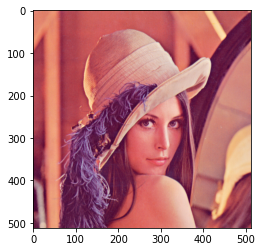

In [3]:
# 処理の対象となる画像をread
img = cv2.imread('img/lenna.png')
h, w = img.shape[:2]
print(f'heit: {h}  width: {w}')
show_img_cv2(img)

### 2.2　アフィン変換：cv2.warpAffine()を使って画像を回転

アフィン行列：
[[  0.98480775   0.17364818 -30.17196144]
 [ -0.17364818   0.98480775  55.1329027 ]]


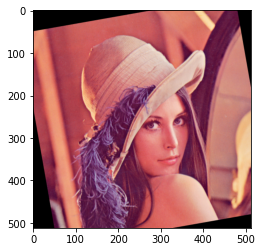

In [4]:
mat1 = cv2.getRotationMatrix2D((300, 200), 10, 1)
print('アフィン行列：')
print(mat1)
rotated_img1 = cv2.warpAffine(img, mat1, (w, h))
cv2.imwrite('affine_img.png', rotated_img1)
show_img_cv2(rotated_img1)

### 2.3　射影変換：cv2.warpPerspective()を使って画像を回転

射影変換行列：
[[  0.98480775   0.17364818 -30.17196144]
 [ -0.17364818   0.98480775  55.1329027 ]
 [  0.           0.           1.        ]]


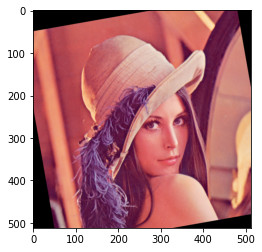

In [5]:
mat2 = np.concatenate([mat1, np.array([[0, 0, 1]])], 0)
print('射影変換行列：')
print(mat2)
rotated_img2 = cv2.warpPerspective(img, mat2, (w, h))
cv2.imwrite('perspected_img.png', rotated_img2)
show_img_cv2(rotated_img2)

#### アフィン変換、射影変換で、同じ回転画像が得られた。

### 2.4　処理時間の比較
timeitモジュールを使って、10000回ずつ処理を繰り返した際の平均処理時間を求める

In [6]:
import timeit
loop = 10000
result1 = timeit.timeit(lambda: cv2.warpAffine(img, mat1, (w, h)), number=loop)
print(f'warpAffine : {result1 / loop}')

result2 = timeit.timeit(lambda: cv2.warpPerspective(img, mat2, (w, h)), number=loop)
print(f'warpPerspective : {result2 / loop}')


warpAffine : 0.0010326173099980225
warpPerspective : 0.0012882464599970262


## ３．結論
#### warpPerspective()はwarpAffine()に比べると少し遅い